In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from simulation_configs import generateConfigurations
from simulation_modules import DisturbanceModule, ProcessModule
import inspect
import pandas as pd
import time as real_time

In [2]:
# Repeatable results
np.random.seed(85)

In [3]:
# Generate configurations
t, d, u, p, x, f, y, r, m, econ = generateConfigurations()

In [4]:
# Inputs
u

{'x0v': 0.5,
 'xFv': 0.5,
 'xWv': 0.5,
 'PI': {'K': 0.1, 'tauI': 10},
 'intError': 0,
 'control': True,
 'dt': 100}

In [5]:
# Process parameters
p

{'A': 4,
 'cv': 0.025,
 'kv': 0.02,
 'tauv': 60,
 'dt': 100,
 'levelThreshold': 0.0005}

In [6]:
# States and intermediate variables
x

{'V': 0.004,
 'CV': 0,
 'xWv': 0,
 'C': 0.0,
 'L': 0.001,
 'F0': 0.0025,
 'FW': 0.0,
 'F': 0.00031622776601683794}

In [7]:
# Process module
print(inspect.getsource(ProcessModule))

def ProcessModule(p, u, d_now, x, f, t):
    # ODEs
    def processODE(p, u, d_now, x_CV, x_V, x_xWv, f):
        # Edge cases
        x_xWv = max(0, min(x_xWv,1))
        
        # Intermediate variables
        x_C = x_CV/x_V
        x_L = max(p['levelThreshold'], x_V/p['A'])
        x_F0 = u['x0v']*d_now['F0']
        x_FW = x_xWv*p['cv']
        x_F = u['xFv']*p['kv']*np.sqrt(x_L)

        # Differential equations
        dVdt = x_F0 + x_FW - x_F
        dCVdt = d_now['C0']*x_F0 - x_C*x_F
        dxWvdt = (1/p['tauv'])*(u['xWv'] - x_xWv)
        
        # Check for fault: fail open water valve,
        if f['valveFW']['state']=='stuck' and u['control']:
            dxWvdt = 10 # fail open
        
        return dVdt, dCVdt, dxWvdt
    
    # Derivatives: Hard-coded Runge-Kutta 4th order
    k1V, k1CV, k1xWv = processODE(p, u, d_now, x['CV'], x['V'], x['xWv'], f)
    x1V = x['V'] + k1V*t['deltat']/2
    x1CV = x['CV'] + k1CV*t['deltat']/2
    x1xWv = max(0,min(x['xWv'] + k1xWv*t[

In [8]:
# Generate disturbances
d_range = DisturbanceModule(d,t)

In [9]:
# Simulation
# Start timer for simulation duration
start_time = real_time.time()
# List of variables to save
results_list = ['Time (days)', 'V', 'xWv', 'C', 'L', 'F0', 'FW', 'F', 'C0']
# Preallocate numpy array to store results
results = np.full((t['N'], len(results_list)),np.nan)
# Indicate whether input changes
input_change = True
input_change_time_index = 0.1*24*3600/t['deltat'] # 2 days
# Start simulation
print('Simulation progress:')
while t['tvector'][t['i']] < t['tmax']: # necessary while loop, since shuts can skip forward in time
    # Update time (check for jumps from maintenance)
    t['tvector'][t['i']+1] = t['tvector'][t['i']] + t['deltat']
    # Current disturbance
    d_now = {col: d_range[col][t['i']] for col in ['F0', 'C0']}
    # Current input
    if input_change and t['i']>=input_change_time_index:
        u['xWv'] = 0.6
    # Process module
    x = ProcessModule(p, u, d_now, x, f, t)
    # Update results
    results[t['i'], :] = [t['tvector'][t['i']]/(3600*24),
                          x['V'], 
                          x['xWv'], 
                          x['C'], 
                          x['L'], 
                          x['F0'], 
                          x['FW'], 
                          x['F'], 
                          d_now['C0']]
    # Display progress in percent time
    if t['tvector'][t['i']] % (2*24*3600) == 0:
        print(f'{t["tvector"][t["i"]]/t["tmax"]*100:.2f}%')
    # Update time index
    t['i'] += 1

# End timer for simulation duration
end_time = real_time.time()
# Print simulation duration
print(f'Done! Simulation duration: {end_time-start_time:.1f} seconds.')

Simulation progress:
0.00%
7.14%
14.29%
21.43%
28.57%
35.71%
42.86%
50.00%
57.14%
64.29%
71.43%
78.57%
85.71%
92.86%
Done! Simulation duration: 0.8 seconds.


In [10]:
# Convert results (numpy array) to DataFrame
df = pd.DataFrame(results, columns=results_list)
df.set_index('Time (days)', inplace=True)

In [11]:
x

{'V': 12.37545611374422,
 'CV': 2.176331532139688,
 'xWv': 0.6,
 'C': 0.1758586925715528,
 'L': 3.093864028436055,
 'F0': 0.002922138500483491,
 'FW': 0.015,
 'F': 0.017589383242274458}

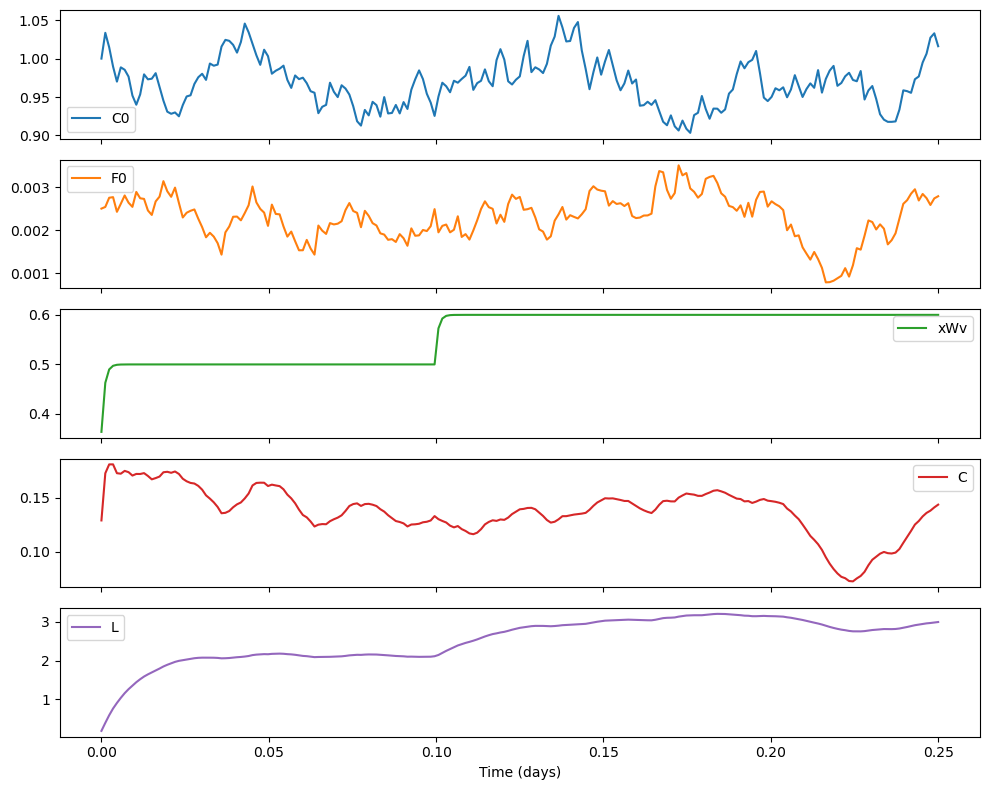

In [12]:
# Plot
startInd = 0
endInd = 0.25
plot_list = ['C0','F0','xWv','C','L']
df[plot_list].loc[startInd:endInd].plot(subplots=True, figsize=(10,8))
plt.tight_layout()